## Reconhecimento de caracteres do MNIST

Vamos treinar um modelo composto por uma transformação afim mais uma camada softmax em uma tarefa de classificação multiclasse: classificando os rótulos de dígitos para imagens de dígitos manuscritos a partir do conjunto de dados MNIST.

A primeira célula é utilizada para se importar os módulos e classes necessários tendo em vista carregar os objetos do fornecedor de dados MNIST. Como é preciso um pouco para carregar os dados do MNIST do disco na memória, vale a pena carregar os provedores de dados apenas uma vez em uma célula separada, como essa, em vez de recriar os objetos para cada execução de treinamento.

Estamos carregando dois objetos de provedor de dados aqui - um correspondente ao conjunto de dados de treinamento e um segundo a ser usado como um conjunto de dados de * validação *. Estes são dados em que não treinamos o modelo, mas medimos o desempenho do modelo treinado para avaliar sua capacidade de * generalizar * para dados não vistos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 10

In [2]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

A execução da célula abaixo criará um modelo consistente em um seguidor de camada afim (função afim) por uma transformação do tipo softmax e treiná-lo no conjunto de dados MNIST, minimizando a função de erro de entropia cruzada multi-classe usando uma regra de aprendizado de descida de gradiente básico. Ao usar a função auxiliar definida acima, no final das curvas de treinamento da evolução da função de erro, e a precisão de classificação do modelo durante as épocas de treinamento serão traçadas.

Vamos tentar executar o código para várias configurações dos hiperparâmetros de treinamento definidos no início da célula para ter uma idéia de como eles afetam a forma como o treinamento prossegue.

### Escala de inicialização variável

<span style="color:red">Vamos tentar diferentes parâmetros de inicialização</span>

#### `init_scale = 0.01`

Epoch 5: 6.4s to complete
    error(train)=3.10e-01, acc(train)=9.14e-01, error(valid)=2.91e-01, acc(valid)=9.18e-01
Epoch 10: 5.4s to complete
    error(train)=2.88e-01, acc(train)=9.20e-01, error(valid)=2.76e-01, acc(valid)=9.23e-01
Epoch 15: 3.5s to complete
    error(train)=2.78e-01, acc(train)=9.23e-01, error(valid)=2.69e-01, acc(valid)=9.24e-01
Epoch 20: 4.2s to complete
    error(train)=2.71e-01, acc(train)=9.25e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 25: 4.7s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.65e-01, acc(valid)=9.26e-01
Epoch 30: 3.7s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.26e-01
Epoch 35: 3.8s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 40: 4.2s to complete
    error(train)=2.59e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.29e-01
Epoch 45: 4.3s to complete
    error(train)=2.55e-01, acc

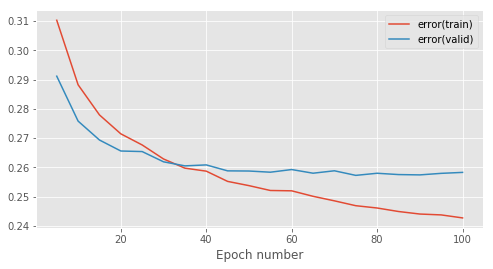

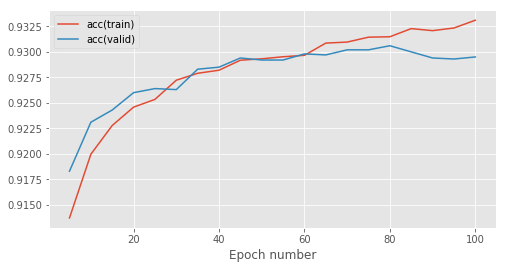

In [3]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `init_scale = 0.1`

Epoch 5: 3.8s to complete
    error(train)=3.11e-01, acc(train)=9.13e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 10: 4.0s to complete
    error(train)=2.89e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.23e-01
Epoch 15: 3.7s to complete
    error(train)=2.79e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.24e-01
Epoch 20: 5.4s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 25: 4.7s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 30: 4.2s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.26e-01
Epoch 35: 4.0s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 40: 4.3s to complete
    error(train)=2.59e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 4.5s to complete
    error(train)=2.55e-01, acc

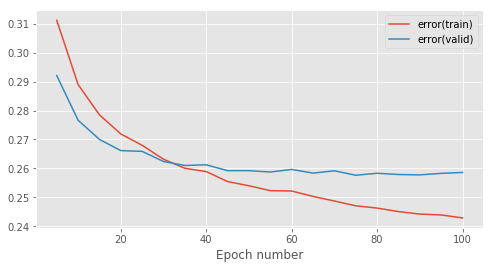

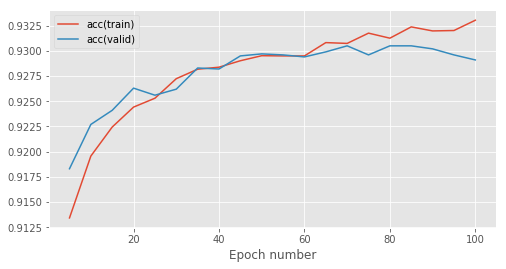

In [4]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `init_scale = 0.5`

Epoch 5: 3.7s to complete
    error(train)=3.38e-01, acc(train)=9.03e-01, error(valid)=3.17e-01, acc(valid)=9.11e-01
Epoch 10: 4.3s to complete
    error(train)=3.06e-01, acc(train)=9.13e-01, error(valid)=2.94e-01, acc(valid)=9.17e-01
Epoch 15: 3.3s to complete
    error(train)=2.92e-01, acc(train)=9.17e-01, error(valid)=2.83e-01, acc(valid)=9.20e-01
Epoch 20: 5.5s to complete
    error(train)=2.82e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.22e-01
Epoch 25: 3.8s to complete
    error(train)=2.77e-01, acc(train)=9.22e-01, error(valid)=2.75e-01, acc(valid)=9.22e-01
Epoch 30: 4.3s to complete
    error(train)=2.71e-01, acc(train)=9.24e-01, error(valid)=2.71e-01, acc(valid)=9.25e-01
Epoch 35: 3.9s to complete
    error(train)=2.67e-01, acc(train)=9.25e-01, error(valid)=2.69e-01, acc(valid)=9.26e-01
Epoch 40: 4.4s to complete
    error(train)=2.65e-01, acc(train)=9.27e-01, error(valid)=2.68e-01, acc(valid)=9.26e-01
Epoch 45: 4.2s to complete
    error(train)=2.61e-01, acc

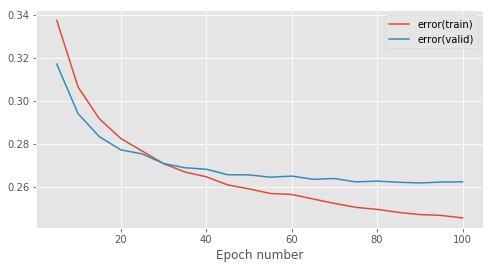

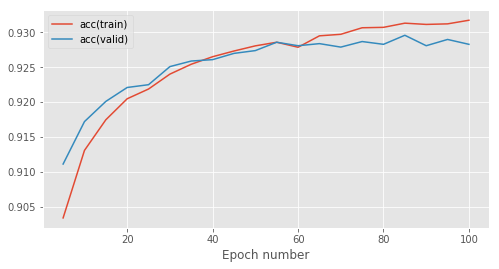

In [5]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.5  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

|`init_scale`| Final `error(train)` | Final `error(valid)` |
|------------|----------------------|----------------------|
| 0.01       | 2.43e-01             | 2.58e-01             |
| 0.1        | 2.43e-01             | 2.59e-01             |
| 0.5        | 2.45e-01             | 2.62e-01             |

<span style="color:red">
Uma escala de inicialização maior de 0,5 parece dar uma aprendizagem inicial ligeiramente mais lenta do que escalas menores de 0,1 e 0,01, porém a diferença é apenas leve sugerindo que este desempenho de treinamento superficial da arquitetura não seja particularmente sensível à escala de inicialização.
</span>

### Variações da Taxa de Aprendizagem

<span style="color:red">Agora vamos tentar alguns valores diferentes para a taxa de aprendizagem.</span>

#### `learning_rate = 0.05`

Epoch 5: 4.0s to complete
    error(train)=3.41e-01, acc(train)=9.05e-01, error(valid)=3.16e-01, acc(valid)=9.12e-01
Epoch 10: 4.0s to complete
    error(train)=3.10e-01, acc(train)=9.14e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 15: 5.1s to complete
    error(train)=2.97e-01, acc(train)=9.18e-01, error(valid)=2.82e-01, acc(valid)=9.21e-01
Epoch 20: 4.1s to complete
    error(train)=2.88e-01, acc(train)=9.20e-01, error(valid)=2.76e-01, acc(valid)=9.23e-01
Epoch 25: 4.4s to complete
    error(train)=2.83e-01, acc(train)=9.21e-01, error(valid)=2.73e-01, acc(valid)=9.24e-01
Epoch 30: 3.9s to complete
    error(train)=2.77e-01, acc(train)=9.22e-01, error(valid)=2.69e-01, acc(valid)=9.24e-01
Epoch 35: 3.7s to complete
    error(train)=2.74e-01, acc(train)=9.24e-01, error(valid)=2.67e-01, acc(valid)=9.25e-01
Epoch 40: 4.0s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 45: 3.7s to complete
    error(train)=2.68e-01, acc

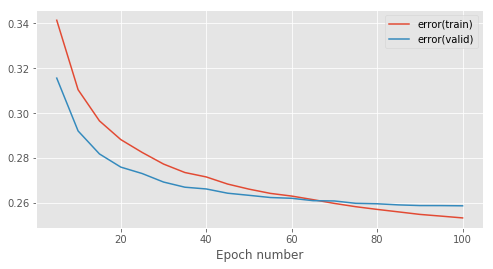

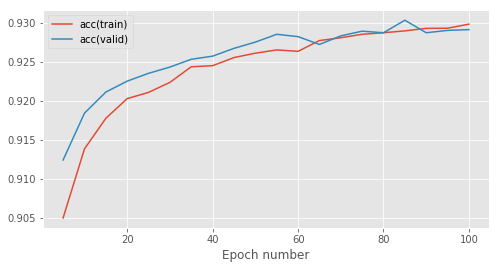

In [6]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.05  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `learning_rate = 0.1`

Epoch 5: 5.1s to complete
    error(train)=3.11e-01, acc(train)=9.13e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 10: 3.4s to complete
    error(train)=2.89e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.23e-01
Epoch 15: 3.8s to complete
    error(train)=2.79e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.24e-01
Epoch 20: 3.4s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 25: 4.3s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 30: 3.9s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.26e-01
Epoch 35: 4.5s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 40: 5.9s to complete
    error(train)=2.59e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 4.0s to complete
    error(train)=2.55e-01, acc

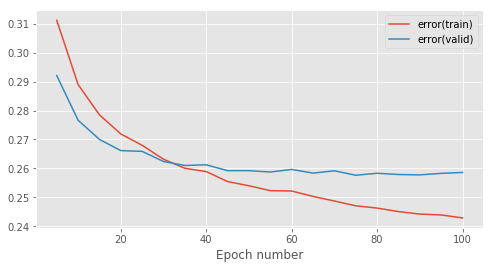

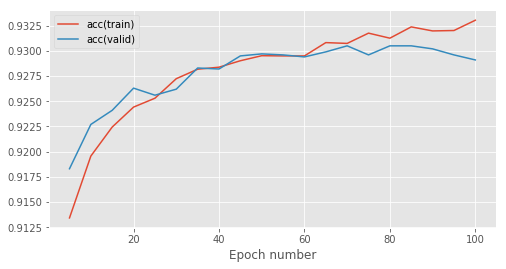

In [7]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `learning_rate = 0.2`

Epoch 5: 3.5s to complete
    error(train)=2.90e-01, acc(train)=9.19e-01, error(valid)=2.77e-01, acc(valid)=9.22e-01
Epoch 10: 3.8s to complete
    error(train)=2.75e-01, acc(train)=9.23e-01, error(valid)=2.69e-01, acc(valid)=9.25e-01
Epoch 15: 5.3s to complete
    error(train)=2.66e-01, acc(train)=9.26e-01, error(valid)=2.64e-01, acc(valid)=9.26e-01
Epoch 20: 4.3s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 25: 4.9s to complete
    error(train)=2.57e-01, acc(train)=9.28e-01, error(valid)=2.64e-01, acc(valid)=9.27e-01
Epoch 30: 5.0s to complete
    error(train)=2.53e-01, acc(train)=9.29e-01, error(valid)=2.61e-01, acc(valid)=9.30e-01
Epoch 35: 4.2s to complete
    error(train)=2.50e-01, acc(train)=9.30e-01, error(valid)=2.60e-01, acc(valid)=9.30e-01
Epoch 40: 4.0s to complete
    error(train)=2.49e-01, acc(train)=9.31e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 4.4s to complete
    error(train)=2.45e-01, acc

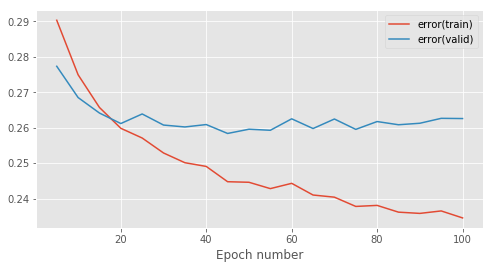

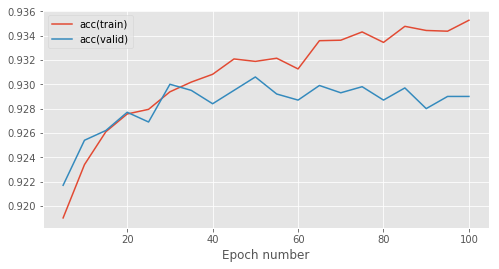

In [8]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.2  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `learning_rate = 0.5`

Epoch 5: 3.5s to complete
    error(train)=2.79e-01, acc(train)=9.20e-01, error(valid)=2.74e-01, acc(valid)=9.23e-01
Epoch 10: 3.7s to complete
    error(train)=2.68e-01, acc(train)=9.24e-01, error(valid)=2.72e-01, acc(valid)=9.26e-01
Epoch 15: 3.9s to complete
    error(train)=2.55e-01, acc(train)=9.28e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 20: 3.5s to complete
    error(train)=2.49e-01, acc(train)=9.31e-01, error(valid)=2.61e-01, acc(valid)=9.29e-01
Epoch 25: 4.3s to complete
    error(train)=2.52e-01, acc(train)=9.29e-01, error(valid)=2.73e-01, acc(valid)=9.25e-01
Epoch 30: 3.5s to complete
    error(train)=2.47e-01, acc(train)=9.31e-01, error(valid)=2.70e-01, acc(valid)=9.27e-01
Epoch 35: 3.2s to complete
    error(train)=2.44e-01, acc(train)=9.32e-01, error(valid)=2.69e-01, acc(valid)=9.27e-01
Epoch 40: 4.1s to complete
    error(train)=2.44e-01, acc(train)=9.32e-01, error(valid)=2.72e-01, acc(valid)=9.26e-01
Epoch 45: 4.3s to complete
    error(train)=2.36e-01, acc

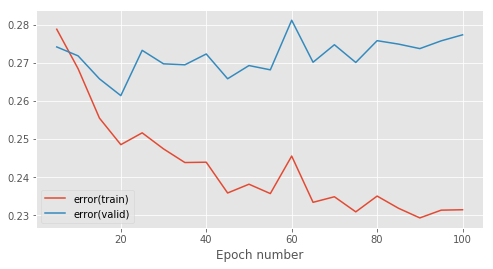

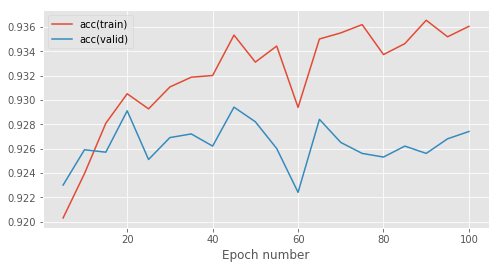

In [9]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.5  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

|`learning_rate`| Final `error(train)` | Final `error(valid)` |
|---------------|----------------------|----------------------|
| 0.05          | $2.53\times 10^{-1}$  | $2.59\times 10^{-1}$|
| 0.1           | $2.43\times 10^{-1}$  | $2.59\times 10^{-1}$|
| 0.2           | $2.35\times 10^{-1}$  | $2.63\times 10^{-1}$|
| 0.5           | $2.31\times 10^{-1}$  | $2.77\times 10^{-1}$|

<span style="color:red">
Aumentando a taxa de aprendizado, como era esperado, também aumenta a velocidade de aprendizado, com o erro de treinamento final sendo atingido de forma monotônica se diminuindo as taxas de aprendizado testadas à medida que a taxa de aprendizado aumentava. 

Observe, no entanto, que o erro de conjunto de validação aumenta para maiores taxas de aprendizado - isso sugere que o modelo está tendo overfitting de acordo com os dados, com as maiores taxas de aprendizado causando que o modelo comece a ter overfitting mais cedo - poderíamos ter conseguido parar de aprender mais cedo nesses casos quando não havia melhoria no * erro * de conjunto de validação. 

Observe também que as curvas de erro para o maior valor da taxa de aprendizado são muito mais *ruidozas*, sugerindo que o aprendizado está se tornando bastante instável com esse grande tamanho de etapa, com um monte de etapas de descida gradiente se ultrapassando (overshooting) e causando o aumento do valor da função de erro.
</span>